<a href="https://colab.research.google.com/github/Abrx1921/Data-Science-Portfolio/blob/main/Project_5_NLP_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 5 - NLP

Abraham Saenz Sigala

11/10/2025

## Problem Definition


Given a dataset of famous people with short descriptions, the goal is to find which people are most similar to a chosen target person based on the meaning of their text. Then compare that similarity using short descriptions (CSV) vs full Wikipedia articles, and analyze if the similarity ranking changes.

This project is an unsupervised learning problem, because of this, we will be creating a clustering model. The target person is only used as a reference for comparison, not a training label.

## Data Collection/Sources


#### Part 1:

The CSV file is available at:

https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv

#### Part 2:

The Wiki to each person is available via search at:

https://en.wikipedia.org/wiki/Main_Page?utm_source=chatgpt.com

## Set Up

In [ ]:
%%capture output
#install Wikipedia API
!pip3 install wikipedia-api

In [ ]:
# Load necessary libraries

import numpy as np
import pandas as pd

# Sentiment analysis
from textblob import TextBlob # Provides polarity & subjectivity scores

# Text representation tools
from sklearn.feature_extraction.text import CountVectorizer   # Converts text to word counts
from sklearn.feature_extraction.text import TfidfVectorizer    # Converts text to TF-IDF representation
from sklearn.feature_extraction.text import TfidfTransformer   # Transforms counts to TF-IDF (if needed separately)

import wikipediaapi # Used to fetch full Wikipedia page text

# NLTK downloads for tokenization / POS tagging / lemmatization support
import nltk

# Tokenizer data (splits text into words/sentences)
nltk.download('punkt_tab')

# Optional resources (uncomment if needed):
# nltk.download('omw-1.4') # Helps with lemmatization (word meaning data)
# nltk.download('averaged_perceptron_tagger_eng') # Part-of-speech tagging

# Allow pandas to show more columns when printing data (for easier viewing)
pd.options.display.max_columns = 100

from sklearn.neighbors import NearestNeighbors


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Load url

url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv"

## Part  1:

## Initial Data Exploration

In [ ]:
famous_people = pd.read_csv(url)
famous_people


,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...
...,...,...,...
42781,<http://dbpedia.org/resource/Motoaki_Takenouchi>,Motoaki Takenouchi,motoaki takenouchi born july 8 1967 saitama pr...
42782,<http://dbpedia.org/resource/Alan_Judge_(footb...,"Alan Judge (footballer, born 1960)",alan graham judge born 14 may 1960 is a retire...
42783,<http://dbpedia.org/resource/Eduardo_Lara>,Eduardo Lara,eduardo lara lozano born 4 september 1959 in c...
42784,<http://dbpedia.org/resource/Tatiana_Faberg%C3...,Tatiana Faberg%C3%A9,tatiana faberg is an author and faberg scholar...


In [ ]:
famous_people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42786 entries, 0 to 42785
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URI     42786 non-null  object
 1   name    42786 non-null  object
 2   text    42786 non-null  object
dtypes: object(3)
memory usage: 1002.9+ KB


In [ ]:
famous_people[famous_people['name'].str.contains('')].sample() # Finding a person

,URI,name,text
11787,<http://dbpedia.org/resource/Laurent_Korcia>,Laurent Korcia,laurent korcia is a french violinist who studi...


In [ ]:
famous_people[famous_people['name'] == 'Christian Bale']

,URI,name,text
39695,<http://dbpedia.org/resource/Christian_Bale>,Christian Bale,christian charles philip bale born 30 january ...


In [ ]:
target_name = 'Christian Bale'

In [ ]:
target_text = famous_people.loc[famous_people['name'] == 'Christian Bale', 'text'].iloc[0]
target_text

'christian charles philip bale born 30 january 1974 is an english actor he has starred in both blockbuster films and smaller projects from independent producers and art housesbale first caught the public eye at the age of 13 when he was cast in the starring role of steven spielbergs empire of the sun 1987 based on the original story by j g ballard bale played an english boy who is separated from his parents and subsequently finds himself lost in a japanese internment camp during world war ii in 2000 he garnered critical acclaim for his portrayal of serial killer patrick bateman in american psycho 2000 he is known for going to great lengths to portray characters in film notably for the psychological thriller the machinist 2004 where he lost 63 pounds 285 kg to play the role of trevor reznikbale went on to receive greater commercial recognition and acclaim for his performance as bruce waynebatman in christopher nolans batman begins 2005 the dark knight 2008 and the dark knight rises 2012

Target Person = Christian Bale



## Clean up Text

## Data Cleaning


In [ ]:
import re

def clean_text(txt):
    txt = txt.lower()
    # txt = re.sub(r"\d+", " ", txt)        # remove numbers
    txt = re.sub(r"[^a-z\s]", " ", txt)   # keep letters + spaces
    txt = re.sub(r"\s+", " ", txt)        # collapse spaces
    return txt.strip()


In [ ]:
famous_people['clean_text'] = famous_people['text'].apply(clean_text)

In [ ]:
famous_people.head()

,URI,name,text,clean_text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,digby morrell born october is a former austral...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,henry krvits born december in tallinn better k...


## Bag of Words Using CountVectorizer

In [ ]:
# Perform BOW on entire df specifically for the text column
cv = CountVectorizer(stop_words='english')
bow_vec = cv.fit_transform(famous_people['clean_text'])   # bag of words matrix

In [ ]:
bow_vec.shape

(42786, 399707)

In [ ]:
# Check if count vectorizer took out the words
words = cv.get_feature_names_out()
words[100000:100050]   # 50 words in the vocabulary

array(['dramabaroque', 'dramabetween', 'dramabruce', 'dramacomedy',
       'dramacommunity', 'dramadavies', 'dramadil', 'dramadiscovered',
       'dramadocumentaries', 'dramadocumentary', 'dramady',
       'dramaelizabeth', 'dramaenglish', 'dramaforshaw', 'dramafrom',
       'dramagage', 'dramahe', 'dramaher', 'dramahis', 'dramahorror',
       'dramain', 'dramajames', 'dramajayne', 'dramalab', 'dramalater',
       'dramalogue', 'dramamalachi', 'dramamclane', 'dramanotable',
       'dramansdchhabra', 'dramaon', 'dramaotoole', 'dramapopes',
       'dramarama', 'dramaramas', 'dramaredford', 'dramarelated',
       'dramarysanov', 'dramas', 'dramasborn', 'dramaserik',
       'dramasfollowing', 'dramasfrom', 'dramashe', 'dramasheldon',
       'dramasin', 'dramasince', 'dramasjamie', 'dramaskapoor',
       'dramasmith'], dtype=object)

## TF-IDF transformation

In [ ]:
# Perform the TF-IDF transformation - Option 2 (CountVectorizer (BOW) + TfidfTransformer - better for large datasets)
tfidf = TfidfTransformer()
tfidf_famous = tfidf.fit_transform(bow_vec)

## Nearest Neighbors

In [ ]:
# Fit nearest neighbors
nn = NearestNeighbors(n_neighbors = 11).fit(tfidf_famous)

Create a nearest-neighbor search tool that will return 11 closest points for any query. (1 will be the person themselves + 10 neighbors.) Feed it your TF-IDF vectors so it learns how to compare similarity between people.

In [ ]:
# Find the row index for the target person (first match)
target_idx = famous_people.index[famous_people['name'] == target_name][0]

In [ ]:
# Index for target person
target_idx

np.int64(39695)

In [ ]:
# Query using the target’s vector
distances, indices = nn.kneighbors(tfidf_famous[target_idx])
# tfidf_famous = our vectorized/transformed values


In [ ]:
distances

array([[0.        , 1.2178714 , 1.23120493, 1.23584525, 1.25144556,
        1.25332877, 1.25487074, 1.2593713 , 1.25963451, 1.26850078,
        1.27084017]])

In [ ]:
indices

array([[39695, 28070,  5875, 11156, 38372, 34836, 13993, 39923, 29556,
        13964, 37595]])

In [ ]:
# flatten distances and indices so it looks nice
d = distances[0]
i = indices[0]
d, i

(array([0.        , 1.2178714 , 1.23120493, 1.23584525, 1.25144556,
        1.25332877, 1.25487074, 1.2593713 , 1.25963451, 1.26850078,
        1.27084017]),
 array([39695, 28070,  5875, 11156, 38372, 34836, 13993, 39923, 29556,
        13964, 37595]))

In [ ]:
# Build df of the nn
neighbors_df = pd.DataFrame({
    'index': i,
    'name': famous_people.iloc[i]['name'].values,
    'distances': d
})

In [ ]:
neighbors_df

,index,name,distances
0,39695,Christian Bale,0.000000
1,28070,Amy Adams,1.217871
2,5875,Michael Keaton,1.231205
3,11156,Anne Hathaway,1.235845
4,38372,Liam Neeson,1.251446
5,34836,Michael Caine,1.253329
6,13993,Ralph Fiennes,1.254871
7,39923,Jack Nicholson,1.259371
8,29556,Felicity Huffman,1.259635
9,13964,Jesse Eisenberg,1.268501


## Sentiment Analysis

In [ ]:
# Target person sentiment
target_sentiment = TextBlob(target_text)
target_sentiment.sentiment
print(f'Polarity: {round(target_sentiment.polarity, 6)}')    # -> between -1 and 1 (positive/negative)
print(f'Polarity: {round(target_sentiment.subjectivity, 6)}') # -> 0 (objective) to 1 (opinion-based)

Polarity: 0.189167
Polarity: 0.296667


## Part 2:

## Wikipedia API

In [ ]:
# Set up wikipedia api
wiki = wikipediaapi.Wikipedia(user_agent='james_bond', language='en')

In [ ]:
# Grab target's page
target_page = wiki.page(target_name)

In [ ]:
# Extract the text from targets wiki
target_text = target_page.text

In [ ]:
# Display the text from targets wiki
target_text

'Christian Charles Philip Bale (born 30 January 1974) is an English actor.  Known for his versatility and physical transformations for his roles, he has been a leading man in films of several genres. His accolades include an Academy Award and two Golden Globe Awards, in addition to four British Academy Film Awards nominations. He was one of the highest-paid actors in 2014, and The Independent later named him one of the greatest actors of the 21st century.\nBorn in Wales to English parents, Bale had his breakthrough role at age 13 in Steven Spielberg\'s 1987 war film Empire of the Sun. After more than a decade of leading and supporting roles in films, he gained wider recognition for his portrayals of serial killer Patrick Bateman in the black comedy American Psycho (2000) and the title role in the thriller The Machinist (2004). He played superhero Batman in Christopher Nolan\'s The Dark Knight trilogy (2005–2012), one of the highest-grossing film franchises.\nOutside his work as Batman,

## Text Cleaning

In [ ]:
# Clean my text
target_text_clean = target_text.lower() # converts text to lower case

for c in ["\n", "'s", "'", "  "]:
  target_text_clean = target_text_clean.replace(c," ")

target_text_clean

'christian charles philip bale (born 30 january 1974) is an english actor. known for his versatility and physical transformations for his roles, he has been a leading man in films of several genres. his accolades include an academy award and two golden globe awards, in addition to four british academy film awards nominations. he was one of the highest-paid actors in 2014, and the independent later named him one of the greatest actors of the 21st century. born in wales to english parents, bale had his breakthrough role at age 13 in steven spielberg 1987 war film empire of the sun. after more than a decade of leading and supporting roles in films, he gained wider recognition for his portrayals of serial killer patrick bateman in the black comedy american psycho (2000) and the title role in the thriller the machinist (2004). he played superhero batman in christopher nolan the dark knight trilogy (2005–2012), one of the highest-grossing film franchises. outside his work as batman, bale had

## Target Sentiment

In [ ]:
# Target person sentiment
target_sentiment_wiki = TextBlob(target_text_clean)
target_sentiment_wiki.sentiment
print(f'Polarity: {round(target_sentiment_wiki.polarity, 6)}')    # -> between -1 and 1 (positive/negative)
print(f'Subjectivity: {round(target_sentiment_wiki.subjectivity, 6)}') # -> 0 (objective) to 1 (opinion-based)

Polarity: 0.116411
Subjectivity: 0.321166


## NN Wiki's

In [ ]:
# The names
top_10_nn = pd.DataFrame(famous_people.iloc[i]['name'].values)

In [ ]:
top_10_nn

,0
0,Christian Bale
1,Amy Adams
2,Michael Keaton
3,Anne Hathaway
4,Liam Neeson
5,Michael Caine
6,Ralph Fiennes
7,Jack Nicholson
8,Felicity Huffman
9,Jesse Eisenberg


In [ ]:
# Drop Target
# top_10_nn = top_10_nn.drop(0)

In [ ]:
# Ensure drop
# top_10_nn

In [ ]:
# duplicate column w/ new name
# top_10_nn['nn'] = top_10_nn[0]

In [ ]:
# Ensure drop column 0
# top_10_nn = top_10_nn.drop(columns = 0)

In [ ]:
# Rename column name
top_10_nn = top_10_nn.rename(columns = {0: 'Name'})

In [ ]:
top_10_nn

,Name
0,Christian Bale
1,Amy Adams
2,Michael Keaton
3,Anne Hathaway
4,Liam Neeson
5,Michael Caine
6,Ralph Fiennes
7,Jack Nicholson
8,Felicity Huffman
9,Jesse Eisenberg


In [ ]:
# Clean text func

def clean_text(s):
    s = re.sub(r"[^a-zA-Z]+", " ", s)   # keep letters only
    s = re.sub(r"\s+", " ", s)         # collapse spaces
    return s.strip().lower()           # trim + lowercase

In [ ]:
nn_wikis_text = []      # list to store cleaned wiki text

for nn in top_10_nn['Name']:   # loop over each neighbor's name
    nn_pages = wiki.page(nn)   # get their Wikipedia page
    nn_text = nn_pages.text    # extract the page text
    cleaned = clean_text(nn_text)  # clean the text
    nn_wikis_text.append(cleaned)  # store result

In [ ]:
nn_wikis_text[0]

'christian charles philip bale born january is an english actor known for his versatility and physical transformations for his roles he has been a leading man in films of several genres his accolades include an academy award and two golden globe awards in addition to four british academy film awards nominations he was one of the highest paid actors in and the independent later named him one of the greatest actors of the st century born in wales to english parents bale had his breakthrough role at age in steven spielberg s war film empire of the sun after more than a decade of leading and supporting roles in films he gained wider recognition for his portrayals of serial killer patrick bateman in the black comedy american psycho and the title role in the thriller the machinist he played superhero batman in christopher nolan s the dark knight trilogy one of the highest grossing film franchises outside his work as batman bale had starring roles in a range of films including nolan s period 

In [ ]:
top_10_nn['cleaned_nn_wikis_text'] = nn_wikis_text # add text to df
top_10_nn

,Name,cleaned_nn_wikis_text
0,Christian Bale,christian charles philip bale born january is ...
1,Amy Adams,amy lou adams born august is an american actre...
2,Michael Keaton,michael john douglas born september known prof...
3,Anne Hathaway,anne jacqueline hathaway born november is an a...
4,Liam Neeson,william john neeson born june is an actor from...
5,Michael Caine,sir michael caine born maurice joseph micklewh...
6,Ralph Fiennes,ralph nathaniel twisleton wykeham fiennes born...
7,Jack Nicholson,john joseph nicholson born april is an america...
8,Felicity Huffman,felicity kendall huffman born december is an a...
9,Jesse Eisenberg,jesse adam eisenberg eye z n burg born october...


## Wiki NN

In [ ]:
# Perform BOW on entire df specifically for the text column
cv_2 = CountVectorizer(stop_words='english')
bow_vec_2 = cv_2.fit_transform(top_10_nn['cleaned_nn_wikis_text'])   # bag of words matrix

In [ ]:
bow_vec_2.shape

(11, 7631)

In [ ]:
# Perform the TF-IDF transformation
tfidf_2 = TfidfTransformer()
tfidf_wiki= tfidf_2.fit_transform(bow_vec_2)

In [ ]:
# Fit nearest neighbors
nn = NearestNeighbors(n_neighbors = 11).fit(tfidf_wiki)

In [ ]:
# Find the row index for the target person
target_idx2 = top_10_nn.index[top_10_nn['Name'] == 'Christian Bale'][0]

In [ ]:
target_idx2

np.int64(0)

In [ ]:
# Query using the target’s vector
distances, indices = nn.kneighbors(tfidf_wiki[target_idx2])
# tfidf_famous = our vectorized/transformed values

In [ ]:
distances

array([[0.        , 1.29270673, 1.30679894, 1.3223113 , 1.32740448,
        1.32838159, 1.32925852, 1.33742596, 1.34767517, 1.35827451,
        1.36040342]])

In [ ]:
indices

array([[ 0,  1,  3,  9,  4,  6,  5,  2, 10,  7,  8]])

In [ ]:
# flatten distances and indices so it looks nice
d2 = distances[0]
i2 = indices[0]
d2, i2

(array([0.        , 1.29270673, 1.30679894, 1.3223113 , 1.32740448,
        1.32838159, 1.32925852, 1.33742596, 1.34767517, 1.35827451,
        1.36040342]),
 array([ 0,  1,  3,  9,  4,  6,  5,  2, 10,  7,  8]))

In [ ]:
# Build df of the nn
wiki_df = pd.DataFrame({
    'index': i2,
    'name': top_10_nn.iloc[i2]['Name'].values,
    'distances': d2
})

In [ ]:
wiki_df

,index,name,distances
0,0,Christian Bale,0.000000
1,1,Amy Adams,1.292707
2,3,Anne Hathaway,1.306799
3,9,Jesse Eisenberg,1.322311
4,4,Liam Neeson,1.327404
5,6,Ralph Fiennes,1.328382
6,5,Michael Caine,1.329259
7,2,Michael Keaton,1.337426
8,10,Charlize Theron,1.347675
9,7,Jack Nicholson,1.358275


In [ ]:
neighbors_df

,index,name,distances
0,39695,Christian Bale,0.000000
1,28070,Amy Adams,1.217871
2,5875,Michael Keaton,1.231205
3,11156,Anne Hathaway,1.235845
4,38372,Liam Neeson,1.251446
5,34836,Michael Caine,1.253329
6,13993,Ralph Fiennes,1.254871
7,39923,Jack Nicholson,1.259371
8,29556,Felicity Huffman,1.259635
9,13964,Jesse Eisenberg,1.268501


## Plot Nearest Ranking

In [ ]:
# Add rank columns to each df
neighbors_df = neighbors_df.reset_index(drop=True)
neighbors_df['rank_neighbors'] = neighbors_df.index  # 0–10

wiki_df = wiki_df.reset_index(drop=True)
wiki_df['rank_wiki'] = wiki_df.index  # 0–10

In [ ]:
neighbors_df

,index,name,distances,rank_neighbors
0,39695,Christian Bale,0.000000,0
1,28070,Amy Adams,1.217871,1
2,5875,Michael Keaton,1.231205,2
3,11156,Anne Hathaway,1.235845,3
4,38372,Liam Neeson,1.251446,4
5,34836,Michael Caine,1.253329,5
6,13993,Ralph Fiennes,1.254871,6
7,39923,Jack Nicholson,1.259371,7
8,29556,Felicity Huffman,1.259635,8
9,13964,Jesse Eisenberg,1.268501,9


In [ ]:
wiki_df

,index,name,distances,rank_wiki
0,0,Christian Bale,0.000000,0
1,1,Amy Adams,1.292707,1
2,3,Anne Hathaway,1.306799,2
3,9,Jesse Eisenberg,1.322311,3
4,4,Liam Neeson,1.327404,4
5,6,Ralph Fiennes,1.328382,5
6,5,Michael Caine,1.329259,6
7,2,Michael Keaton,1.337426,7
8,10,Charlize Theron,1.347675,8
9,7,Jack Nicholson,1.358275,9


In [ ]:
# Merge on name
compare = neighbors_df[['name', 'rank_neighbors']].merge(
    wiki_df[['name', 'rank_wiki']],
    on='name'
)

In [ ]:
compare['rank_diff'] = compare['rank_neighbors'] - compare['rank_wiki']
compare

,name,rank_neighbors,rank_wiki,rank_diff
0,Christian Bale,0,0,0
1,Amy Adams,1,1,0
2,Michael Keaton,2,7,-5
3,Anne Hathaway,3,2,1
4,Liam Neeson,4,4,0
5,Michael Caine,5,6,-1
6,Ralph Fiennes,6,5,1
7,Jack Nicholson,7,9,-2
8,Felicity Huffman,8,10,-2
9,Jesse Eisenberg,9,3,6


In [ ]:
import matplotlib.pyplot as plt

([<matplotlib.axis.YTick at 0x7e031271e630>,
 [Text(0, -6, '−6'),
  Text(0, -5, '−5'),
  Text(0, -4, '−4'),
  Text(0, -3, '−3'),
  Text(0, -2, '−2'),
  Text(0, -1, '−1'),
  Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6')])

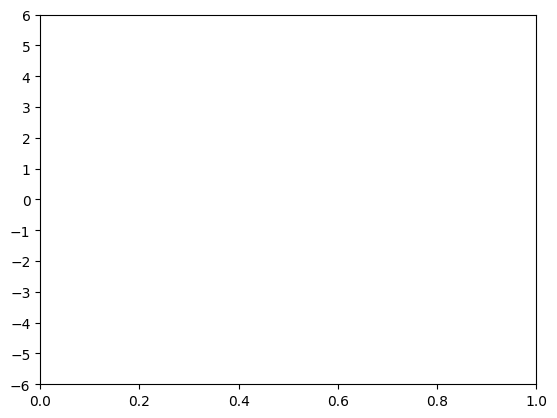

In [ ]:
# Make y-axis symmetric
max_range = compare['rank_diff'].abs().max()
plt.ylim(-max_range, max_range)

# Make ticks evenly spaced
plt.yticks(range(int(-max_range), int(max_range)+1))

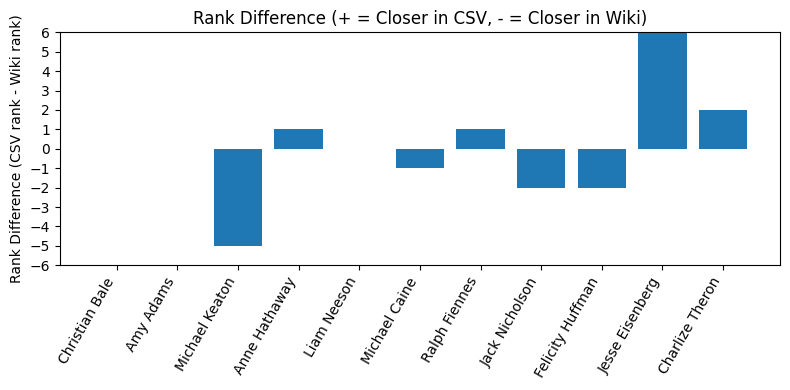

In [ ]:
plt.figure(figsize=(8,4))
plt.bar(compare['name'], compare['rank_diff'])
plt.xticks(rotation=60, ha='right')
plt.ylabel('Rank Difference (CSV rank - Wiki rank)')
plt.title('Rank Difference (+ = Closer in CSV, - = Closer in Wiki)')

# Make y-axis symmetric and clean
max_range = compare['rank_diff'].abs().max()
plt.ylim(-max_range, max_range)
plt.yticks(range(int(-max_range), int(max_range)+1))

plt.tight_layout()

plt.savefig("rank_difference_plot.png", dpi=300, bbox_inches='tight')
plt.show()


The bar chart shows how much the similarity ranking changed when we switched from using the CSV (Part 1) to using the full Wikipedia page (Part 2).

Bars at 0 → Both methods agreed exactly on the ranking for that person.

Positive values → The person appeared more similar to the target when using the CSV text only.

Negative values → The person appeared more similar when using the full Wikipedia page, which contains more detailed background information.

So the direction tells which representation made the person seem closer, and the height tells how big the difference was.

## Part 3:

In [ ]:
# Fit once, outside the function
nn = NearestNeighbors(n_neighbors=11)   # 1 self + 10 neighbors
nn.fit(tfidf_famous)

def pack_a_punch(person_name):
    # Find the row index of the input person
    target_idx = famous_people.index[famous_people['name'] == person_name][0]

    # Get distances & indices of nearest neighbors
    distances, indices = nn.kneighbors(tfidf_famous[target_idx])

    # flatten distances and indices so it looks nice
    d = distances[0]
    i = indices[0]

    return pd.DataFrame({
    'index': i,
    'name': famous_people.iloc[i]['name'].values,
    'distances': d
    })

In [ ]:
# Test
pack_a_punch("Amy Adams")

,index,name,distances
0,28070,Amy Adams,0.000000
1,22804,Julie Walters,1.106310
2,34750,Maggie Smith,1.118514
3,7118,Janet McTeer,1.119477
4,25016,Samantha Morton,1.126456
5,29556,Felicity Huffman,1.141385
6,595,Nicole Kidman,1.142191
7,29003,Barbara Hershey,1.151363
8,11156,Anne Hathaway,1.152024
9,42618,Sigourney Weaver,1.157497


In [ ]:
person = input("Enter a target person: ")
pack_a_punch(person)

Enter a target person: Charlize Theron


,index,name,distances
0,37595,Charlize Theron,0.000000
1,28070,Amy Adams,1.159716
2,29556,Felicity Huffman,1.195502
3,595,Nicole Kidman,1.201045
4,11156,Anne Hathaway,1.201318
5,7118,Janet McTeer,1.216665
6,39923,Jack Nicholson,1.219226
7,16242,Meryl Streep,1.222777
8,5875,Michael Keaton,1.223517
9,25016,Samantha Morton,1.227366


## Other / Misc.

#### Project Desc:

#### Natural Language Processing

This project will give you practical experience using Natural Language Processing techniques. This project is in three parts:
- in part 1) you will use a dataset in a CSV file
- in part 2) you will use the Wikipedia API to directly access content
on Wikipedia.
- in part 3) you will make your notebook interactive

#### Part 1

- The CSV file is available at https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv
- The file contains a list of famous people and a brief overview.
- The goal of part 1) is to ...
  1. Pick one person from the list ( the target person ) and output 10 other people who's overview are "closest" to the target person in a Natural Language Processing sense
  1. Also output the sentiment of the overview of the target person



#### Part 2

- For the same target person that you chose in Part 1), use the Wikipedia API to access the whole content of the target person's Wikipedia page.
- The goal of Part 2) is to ...
  1. Print out the text of the Wikipedia article for the target person
  1. Determine the sentiment of the text of the Wikipedia page for the target person
  1. Collect the text of the Wikipedia pages from the 10 nearest neighbors from Part 1)
  1. Determine the nearness ranking of these 10 people to your target person based on their entire Wikipedia page
  1. Compare, i.e. plot,  the nearest ranking from Step 1) with the Wikipedia page nearness ranking.  A difference of the rank is one means of comparison.



#### Part 3

Make an interactive notebook where a user can choose or enter a name and the notebook displays the 10 closest individuals.

In addition to presenting the project slides, at the end of the presentation each student will demonstrate their code using a famous person suggested by the other students that exists in the DBpedia set.

In [ ]:
!curl -s https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv | wc -l

42786
